In [28]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers


In [29]:
import pathlib

data_dir = pathlib.Path('C:\\Users\\icosane\\Desktop\\New folder\\lorenz_chen_roessler').with_suffix('')


In [30]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

3780


In [31]:
xy = list(data_dir.glob('xy/*'))

In [32]:
batch_size = 32
img_height = 554
img_width = 413

In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3780 files belonging to 9 classes.
Using 3024 files for training.


In [34]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3780 files belonging to 9 classes.
Using 756 files for validation.


In [35]:
class_names = train_ds.class_names
print(class_names)

['chen xy', 'chen zx', 'chen zy', 'lorenz xy', 'lorenz zx', 'lorenz zy', 'roessler yx', 'roessler zx', 'roessler zy']


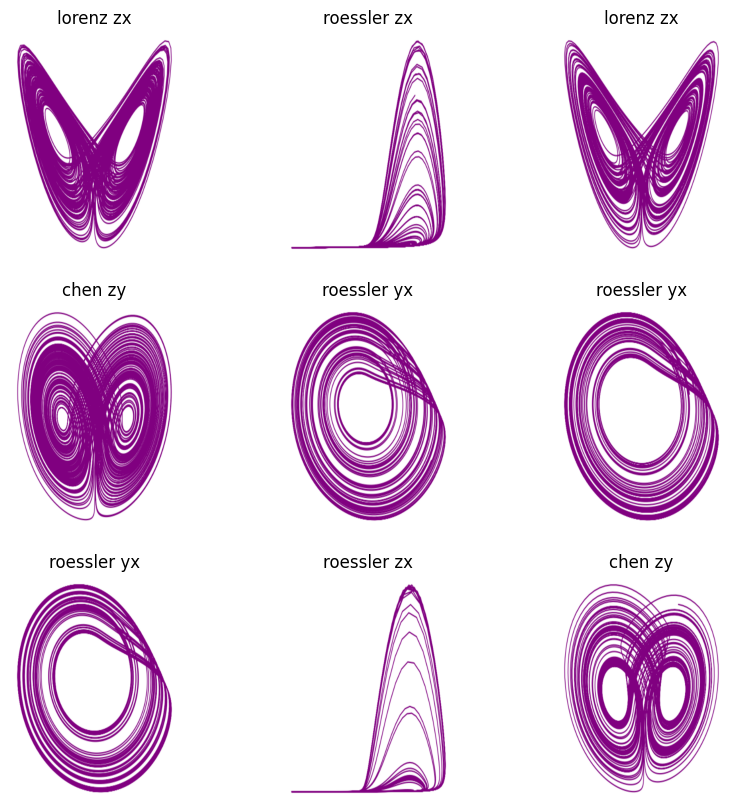

In [36]:

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [37]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [38]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [39]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [40]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
num_classes = 9


model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [42]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [43]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=2
)

Epoch 1/2


95/95 [==============================] - 320s 3s/step - loss: 0.5799 - accuracy: 0.7943 - val_loss: 0.0972 - val_accuracy: 0.9630
Epoch 2/2
95/95 [==============================] - 306s 3s/step - loss: 0.0942 - accuracy: 0.9649 - val_loss: 0.0106 - val_accuracy: 0.9974


In [44]:
model.evaluate(val_ds)

24/24 [==============================] - 12s 512ms/step - loss: 0.0106 - accuracy: 0.9974


[0.010643969289958477, 0.9973545074462891]

In [45]:
for test_images, test_labels in val_ds.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

predictions.shape
predictions[1]
np.argmax(predictions[0])
test_labels[1]

1/1 [==============================] - 1s 749ms/step


2

In [50]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array = predictions_array[i]
  true_label = true_labels[i] 
  img = images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
    
  plt.xlabel("{} ({})".format(class_names[predicted_label],                     
                                      class_names[true_label]),
                                      color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array = predictions_array[i]
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks([0,1,2,3,4,5,6,7,8,9])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

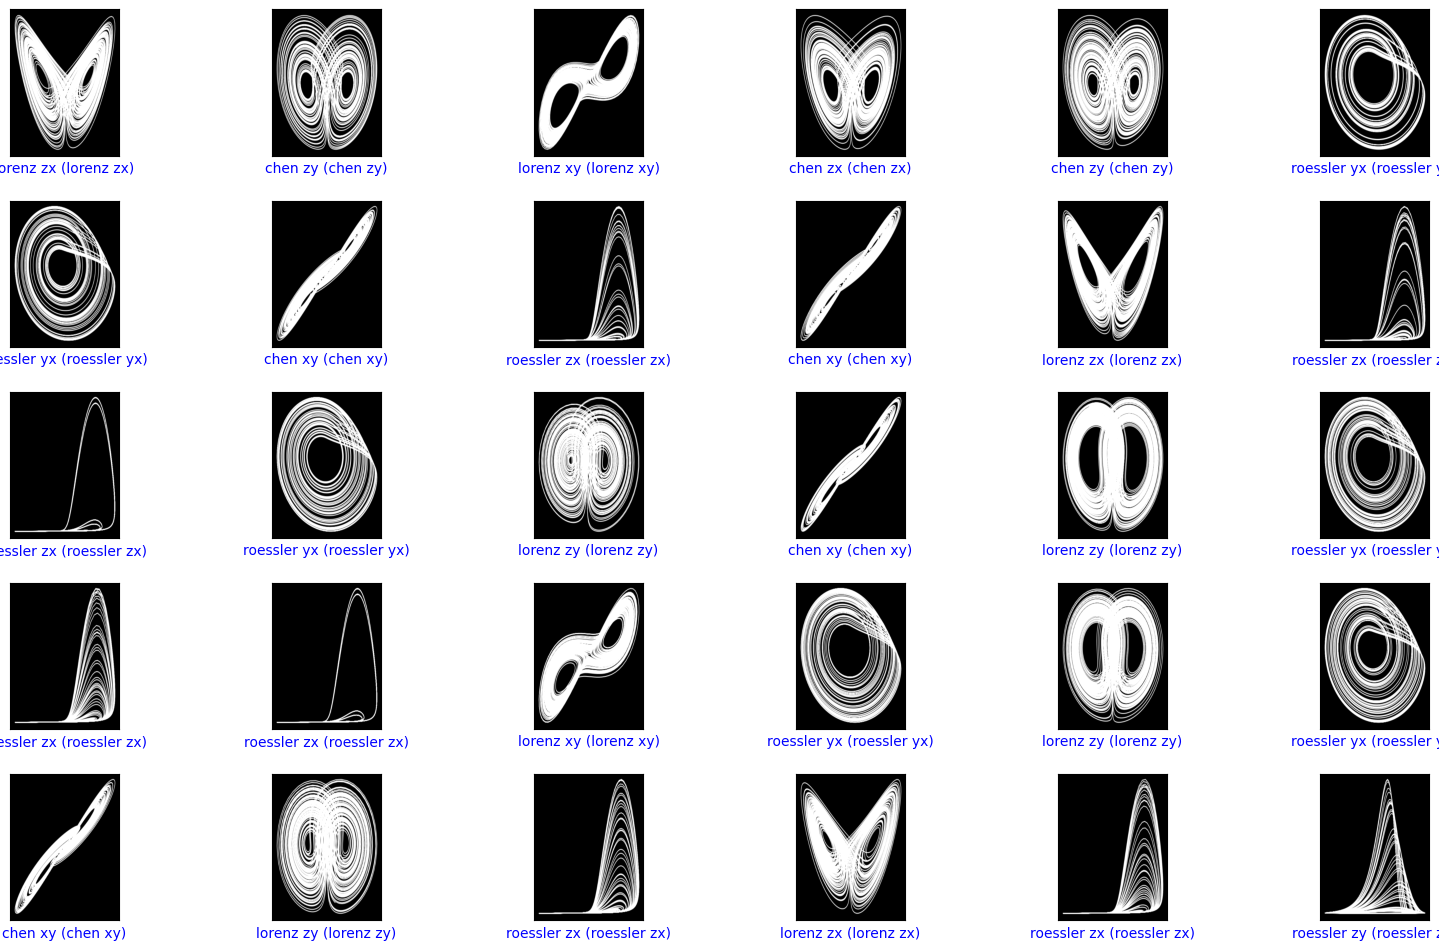

In [51]:
num_rows = 5
num_cols = 6
num_images = num_rows * num_cols
plt.figure(figsize=(2*2*num_rows, 2*num_cols))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i + 1)
  plot_image(i, predictions, test_labels, test_images)

In [52]:
model.save("C:\\Users\\icosane\\Desktop\\New folder\\chen\\_22all_model.h5")

In [53]:
from tensorflow.keras.models import load_model
sm_model = load_model('C:\\Users\\icosane\\Desktop\\New folder\\chen\\_chen_model.h5')

test_score = sm_model.evaluate(test_images, test_labels, verbose=1)
print('Test Loss:', test_score[0])
print('Test Accuracy:', test_score[1])

InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 737, in start

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 607, in run_forever

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1922, in _run_once

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3046, in run_cell

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3101, in _run_cell

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3306, in run_cell_async

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3488, in run_ast_nodes

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3548, in run_code

  File "C:\Users\icosane\AppData\Local\Temp\ipykernel_8948\767649573.py", line 4, in <module>

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2272, in evaluate

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 4079, in run_step

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2042, in test_function

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2025, in step_function

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2013, in run_step

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1895, in test_step

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 2454, in sparse_categorical_crossentropy

  File "c:\Users\icosane\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5777, in sparse_categorical_crossentropy

Received a label value of 8 which is outside the valid range of [0, 6).  Label values: 4 2 3 1 2 6 6 0 7 0 4 7 7 6 5 0 5 6 7 7 3 6 5 6 0 5 7 4 7 8 8 6
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_test_function_7205]

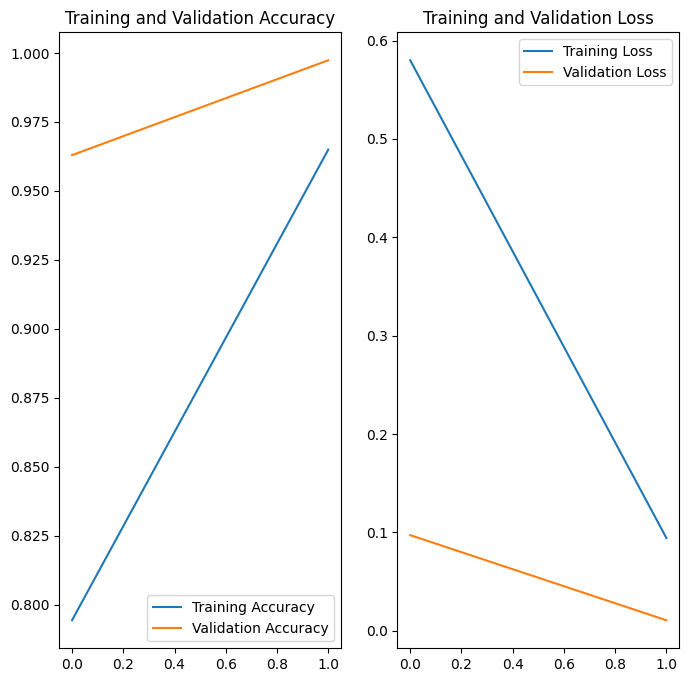

In [54]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(2)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [55]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.concatenate([y for x, y in val_ds], axis=0)
cr = classification_report(y_true, y_pred, output_dict=True, target_names=class_names)
pd.DataFrame.from_dict(cr)

24/24 [==============================] - 13s 553ms/step


,chen xy,chen zx,chen zy,lorenz xy,lorenz zx,lorenz zy,roessler yx,roessler zx,roessler zy,accuracy,macro avg,weighted avg
precision,1.0,1.000000,0.988372,1.000000,0.987500,1.0,1.0,1.0,1.0,0.997354,0.997319,0.997386
recall,1.0,0.987013,1.000000,0.988235,1.000000,1.0,1.0,1.0,1.0,0.997354,0.997250,0.997354
f1-score,1.0,0.993464,0.994152,0.994083,0.993711,1.0,1.0,1.0,1.0,0.997354,0.997268,0.997354
support,87.0,77.000000,85.000000,85.000000,79.000000,77.0,95.0,97.0,74.0,0.997354,756.000000,756.000000


1/1 [==============================] - 0s 132ms/step
This image most likely belongs to lorenz xy with a 70.34 percent confidence.


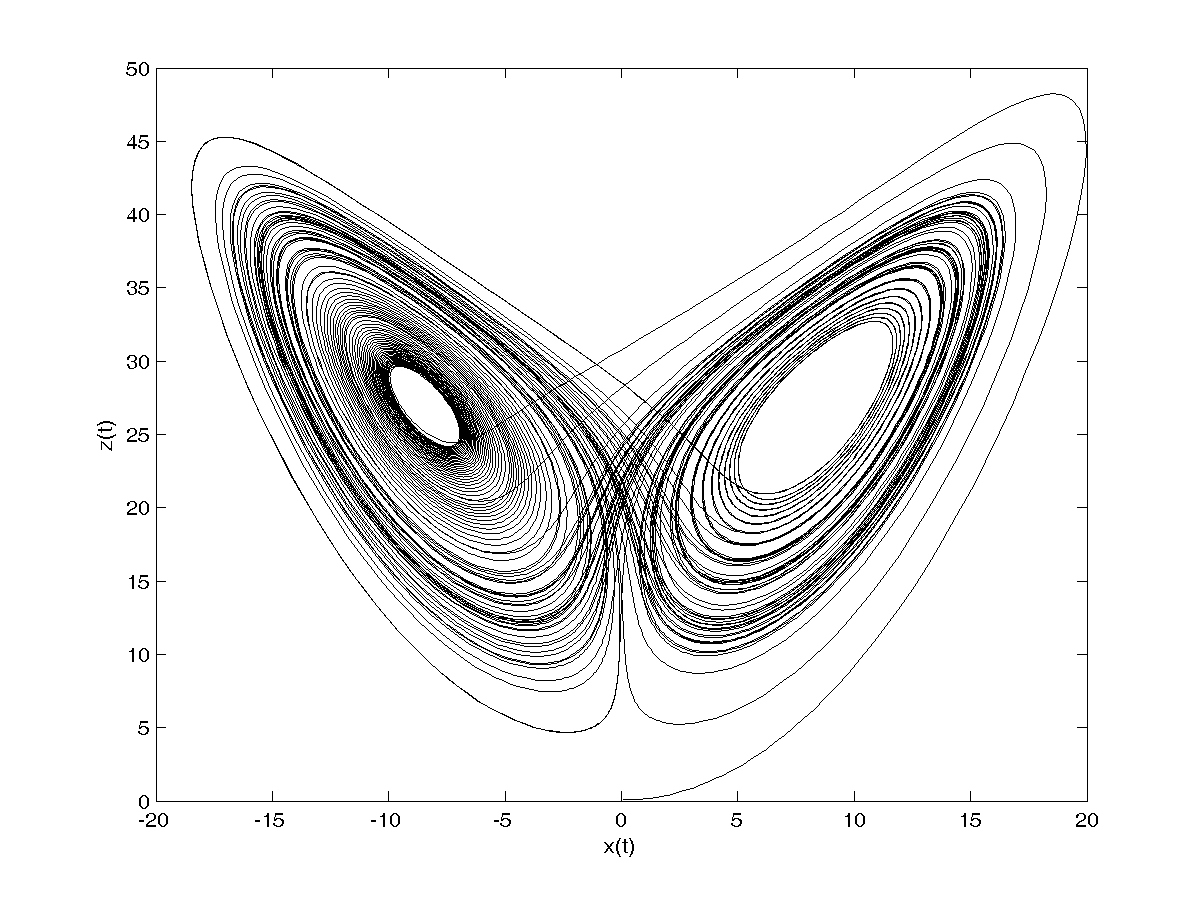

In [56]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\chen 2.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\chen 2.png') 

1/1 [==============================] - 0s 49ms/step
This image most likely belongs to chen xy with a 35.17 percent confidence.


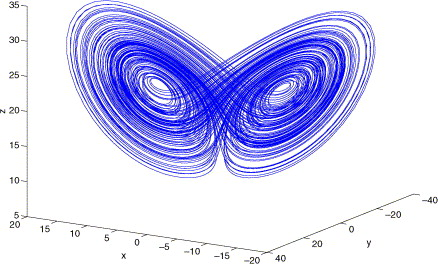

In [57]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\chen 1.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\chen 1.jpg') 

1/1 [==============================] - 0s 51ms/step
This image most likely belongs to roessler yx with a 99.99 percent confidence.


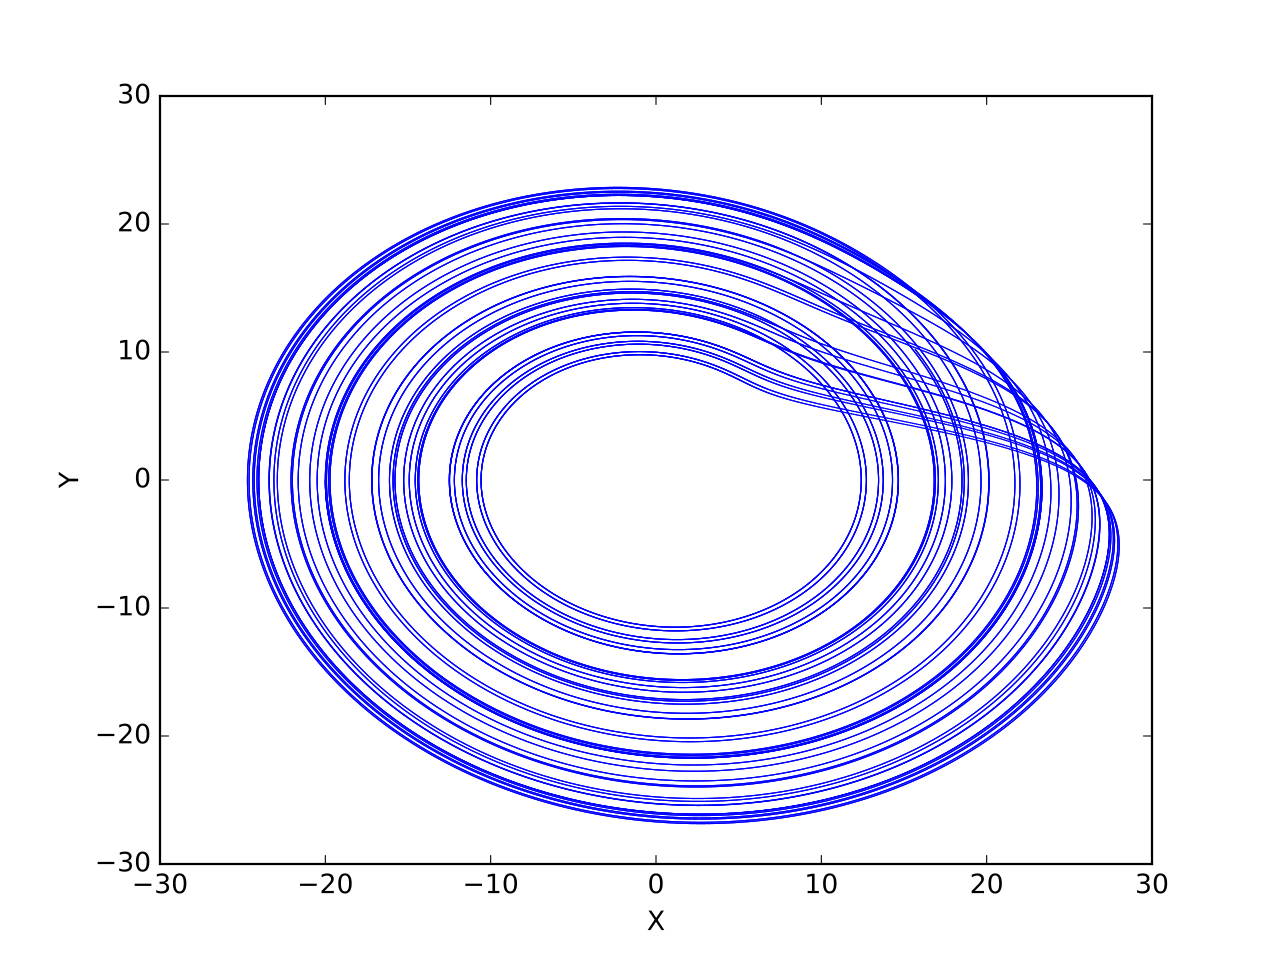

In [58]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 3.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 3.png') 

1/1 [==============================] - 0s 50ms/step
This image most likely belongs to chen xy with a 91.08 percent confidence.


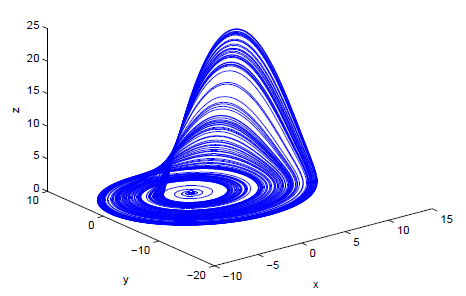

In [59]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 4.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 4.png') 

1/1 [==============================] - 0s 50ms/step
This image most likely belongs to roessler zy with a 90.20 percent confidence.


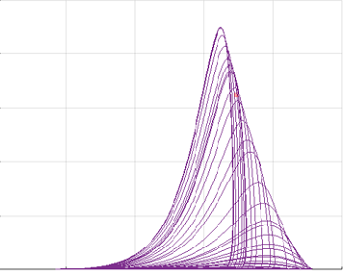

In [60]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 5.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 5.png') 

1/1 [==============================] - 0s 50ms/step
This image most likely belongs to roessler zy with a 98.56 percent confidence.


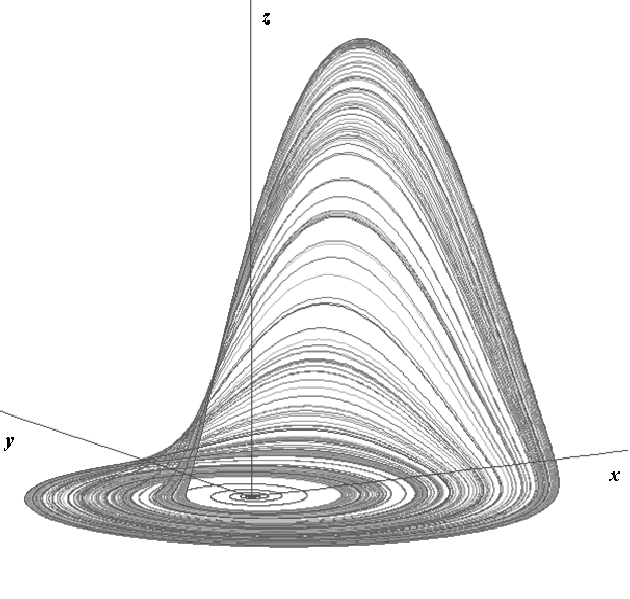

In [61]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 6.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 6.png') 

1/1 [==============================] - 0s 51ms/step
This image most likely belongs to roessler zx with a 99.59 percent confidence.


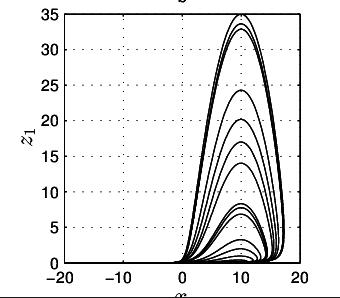

In [62]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 7.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 7.png') 

1/1 [==============================] - 0s 52ms/step
This image most likely belongs to roessler zx with a 65.42 percent confidence.


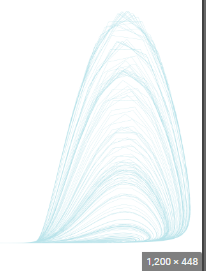

In [63]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 8.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\roessler 9.png') 

1/1 [==============================] - 0s 51ms/step
This image most likely belongs to lorenz xy with a 75.06 percent confidence.


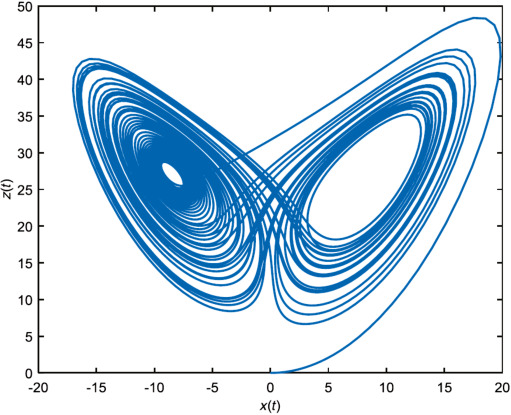

In [64]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 3.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 3.jpg') 

1/1 [==============================] - 0s 53ms/step
This image most likely belongs to chen xy with a 68.48 percent confidence.


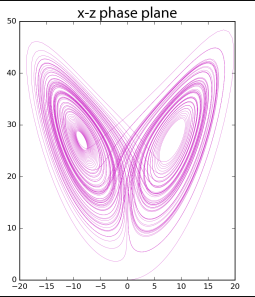

In [65]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 4.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 4.png') 

1/1 [==============================] - 0s 53ms/step
This image most likely belongs to chen zx with a 95.75 percent confidence.


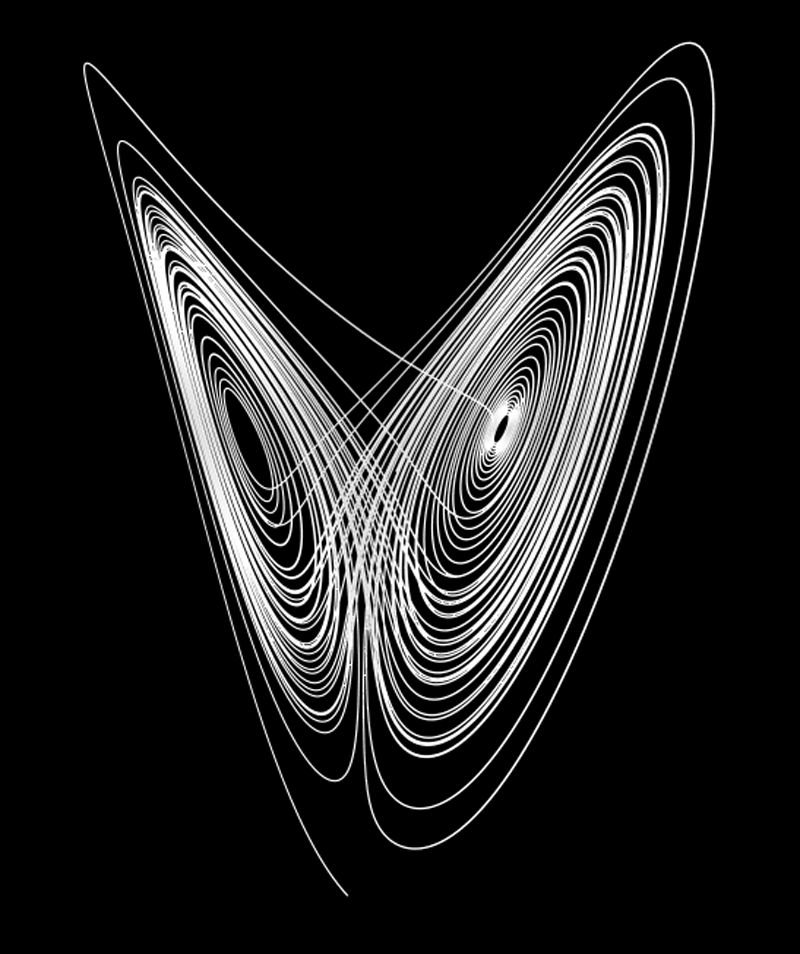

In [66]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 1.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 1.png') 

1/1 [==============================] - 0s 54ms/step
This image most likely belongs to chen xy with a 63.75 percent confidence.


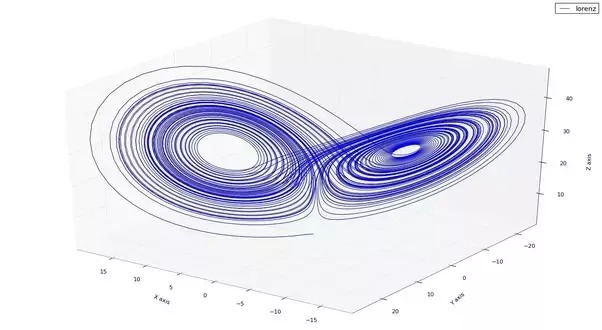

In [67]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 2.jpg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 2.jpg') 

1/1 [==============================] - 0s 52ms/step
This image most likely belongs to chen xy with a 73.83 percent confidence.


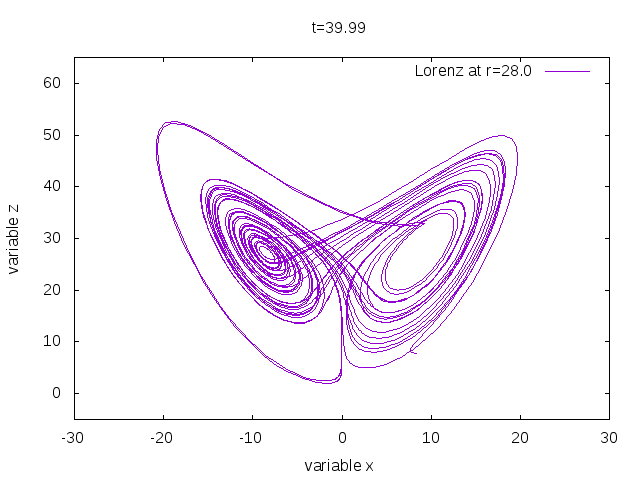

In [68]:
img = tf.keras.utils.load_img(
    'C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 0.png', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
from IPython.display import Image
Image(filename='C:\\Users\\icosane\\Desktop\\New folder\\test\\lorenz 0.png') 